In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random

from copy import deepcopy

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

import Preprocessor
import Parameters
import HHMM
import Visualisor

random.seed(0)
np.random.seed(0)

# Initialize parameters

In [2]:
ndives = 11
ndatasets = 1

# dive duration parameters
dd_mu = np.array([20.0,80.0])
dd_sig = np.array([5.0,50.0])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)
FoVeDBA_sin_shape = np.array([[(5.0/n) for n in range(1,52)],[(5.0/n) for n in range(1,52)]])
FoVeDBA_sin_scale = np.ones((2,51))
FoVeDBA_sin_shape[1,1] = 250
FoVeDBA_sin_shape[1,2] = 50

# average acceleration parameters
acc_mu = np.array([0.0,0.0])
acc_sig = np.array([0.05,0.1])

# number of states for each substate
K0 = 2
K1 = 2

# randomly initialize a probablity transition matrix
ptm_crude = np.array([[0.5,0.5],
                      [0.5,0.5]])

ptm_fine = [np.array([[0.5,0.5],
                      [0.1,0.9]]),
            np.array([[0.8,0.2],
                      [0.3,0.7]])]
    
# randomly intialize a correlation within states
corr_crude = [0.0,0.0]
corr_fine = [0.99,0.95]

# train new models?
train_new = False

# Date of data
date ='07_22_20'

In [3]:
# initialize the initial states
delta_crude = np.ones(K0)/K0
for _ in range(100):
    delta_crude = delta_crude.dot(ptm_crude)
    
delta_fines = []
for k0 in range(K0):
    delta_fine = np.ones(K1)/K1
    for _ in range(100):
        delta_fine = delta_fine.dot(ptm_fine[k0])
    delta_fines.append(delta_fine)

# Create Data 

In [4]:
def create_data():
    
    data = []
    data_V = []
    data_FV = []
    freqs = np.fft.rfftfreq(100, d=1/50.0)
    thresh = 5
    thresh_ind = max(np.where(freqs <= thresh)[0]) + 1
    
    time = 0
    
    for dive_num in range(ndives):
        
        # select dive type
        if dive_num == 0:
            dive_type = np.random.choice(K0,p=delta_crude)
            dd_mu_t = np.copy(dd_mu[dive_type])
        else:
            dive_type_tm1 = dive_type
            dive_type = np.random.choice(K0,p=ptm_crude[dive_type,:])
            dd_mu_t = np.copy(dd_mu[dive_type])
            dd_mu_t = corr_crude[dive_type]*dd_tm1 + (1.0-corr_crude[dive_type])*dd_mu_t

        # select dive duration
        dd_sig_t = dd_sig[dive_type]
        dd_shape_t = np.square(dd_mu_t)/np.square(dd_sig_t)
        dd_scale_t = np.square(dd_sig_t)/np.array(dd_mu_t)

        dive_duration = gamma.rvs(dd_shape_t,0,dd_scale_t)
        dd_tm1 = dive_duration
        datum = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_V = {'dive_type': dive_type, 'dive_duration': dive_duration}
        datum_FV = {'dive_type': dive_type, 'dive_duration': dive_duration}
        nsegs = int(dive_duration/2.0)

        subdive_features = []
        subdive_features_V = []
        subdive_features_FV = []

        for seg_num in range(nsegs):
            
            seg = {}
            seg_V = [{},{}]
            seg_FV = {}

            # find seg type
            if seg_num == 0:
                subdive_type = np.random.choice(K1,p=delta_fines[dive_type])
                acc_mu_t = np.copy(acc_mu[subdive_type])
            else:
                subdive_type = np.random.choice(K1,p=ptm_fine[dive_type][subdive_type,:])
                acc_mu_t = np.copy(acc_mu[subdive_type])
                acc_mu_t = corr_fine[subdive_type]*acc_tm1 + (1.0-corr_fine[subdive_type])*acc_mu_t

            seg['subdive_type'] = subdive_type
            seg_FV['subdive_type'] = subdive_type
            seg_V[0]['subdive_type'] = subdive_type
            seg_V[1]['subdive_type'] = subdive_type

            # find average acceleration
            acc_sig_t = acc_sig[subdive_type]

            # find FoVeDBA
            FoVeDBA_sin = gamma.rvs(FoVeDBA_sin_shape[subdive_type,:],0,FoVeDBA_sin_scale[subdive_type,:])

            seg['FoVeDBA_full'] = FoVeDBA_sin.T
            seg['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
            seg_FV['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001

            # find VeDBA
            pm = (2*np.random.choice(2,size = FoVeDBA_sin.shape)-1)
            FoVeDBA = pm*np.sqrt(FoVeDBA_sin)*1.0j
            A = np.array(np.fft.irfft(FoVeDBA))
            V0 = norm.rvs(acc_mu_t,acc_sig_t)
            acc_tm1 = V0
            A += np.linspace(V0,V0,100).T

            seg['A'] = A
            seg['avg_A'] = np.mean(A)
            seg_V[0]['A'] = np.mean(A[:50])
            seg_V[1]['A'] = np.mean(A[50:])
            seg_FV['A'] = np.mean(A)

            # find time
            seg['time'] = np.arange(time,time+2,1/50)
            time += 2

            subdive_features.append(seg)
            subdive_features_V.append(seg_V[0])
            subdive_features_V.append(seg_V[1])
            subdive_features_FV.append(seg_FV)

        datum['subdive_features'] = subdive_features
        datum_V['subdive_features'] = subdive_features_V
        datum_FV['subdive_features'] = subdive_features_FV

        data.append(datum)
        data_V.append(datum_V)
        data_FV.append(datum_FV)
        
    return data,data_V,data_FV

data,data_V,data_FV = create_data()

0.15147853806850328
0.3115064168180453
[46.50268809]


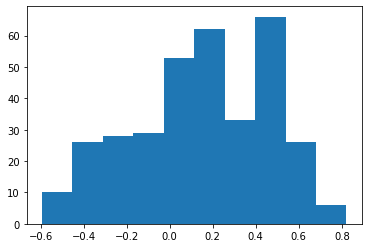

In [5]:
As = []
for dive in data_FV:
    As.extend([seg['A'] for seg in dive['subdive_features']])
plt.hist(As)
print(np.mean(As))
print(np.std(As))
print(np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))]))

# Visualize Data 

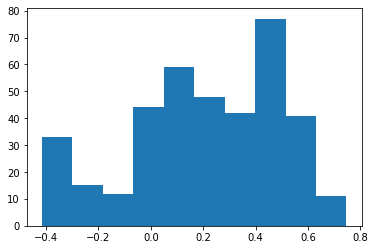

0.2091416021561914
0.28227538085655457


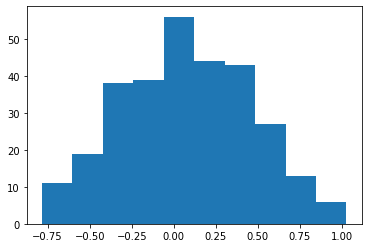

0.07706201617155446
0.38748011292368517


In [6]:
FO0 = []
FO1 = []
for dive in data_V:
    for seg in dive['subdive_features']:
        if seg['subdive_type'] == 0:
            FO0.append(seg['A'])
        else:
            FO1.append(seg['A'])
        
plt.hist(FO0)
plt.show()
print(np.mean(FO0))
print(np.std(FO0))
plt.hist(FO1)
plt.show()
print(np.mean(FO1))
print(np.std(FO1))

# Find intial thetas for training

In [7]:
### CarHMM ###
hmm_FV_theta = [{'dive_duration': {'mu': np.array([np.mean(dd_mu)]),
                                   'sig': np.array([np.sqrt(np.mean(dd_sig**2) + np.var(dd_mu))]),
                                   'corr': np.array([-10.])}},
                 [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

ptm_fine_temp = ptm_fine[0]/2 + ptm_fine[1]/2

hmm_FV_eta = [np.array([[0]]),
             [np.array([[0,np.log(1.0/ptm_fine_temp[0,0]-1)],
                        [np.log(1.0/ptm_fine_temp[1,1]-1),0]])]]


### CarHHMM, no Z2 ###
hhmm_V_theta = [{'dive_duration': {'mu': dd_mu,
                                   'sig': dd_sig,
                                   'corr': np.array([-10.,-10.])}},
                 [{'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}},
                  {'A': {'mu': acc_mu,
                         'sig': acc_sig,
                         'corr': logit(corr_fine)}}]]

hhmm_V_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                        [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
             [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                        [np.log(1.0/ptm_fine[0][1,1]-1),0]]),
              
              np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                        [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]


### HHMM ###
hhmm_FV_uncorr_theta = [{'dive_duration': {'mu': dd_mu,
                                           'sig': dd_sig,
                                           'corr': np.array([-10.,-10.])}},
                         [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                                       'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                                       'corr': np.array([ -10., -10.])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([-10.,-10.])}},
                          {'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                                       'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                                       'corr': np.array([ -10., -10.])},
                           'A': {'mu': acc_mu,
                                 'sig': acc_sig,
                                 'corr': np.array([-10.,-10.])}}]]

hhmm_FV_uncorr_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                                [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
                      [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                                 [np.log(1.0/ptm_fine[0][1,1]-1),0]]),

                       np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                                 [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]

### CarHHMM ###
hhmm_FV_theta = [{'dive_duration': {'mu': dd_mu,
                                    'sig': dd_sig,
                                    'corr': np.array([-10.,-10.])}},
                 [{'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig, 
                         'corr': logit(corr_fine)}},
                 {'FoVeDBA': {'mu': np.sum(FoVeDBA_sin_shape,1),
                               'sig': np.sqrt(np.sum(FoVeDBA_sin_shape,1)),
                               'corr': np.array([ -10., -10.])},
                   'A': {'mu': acc_mu,
                         'sig': acc_sig, 
                         'corr': logit(corr_fine)}}]]

hhmm_FV_eta = [np.array([[0,np.log(1.0/ptm_crude[0,0]-1)],
                         [np.log(1.0/ptm_crude[1,1]-1),0]]), 
              
               [np.array([[0,np.log(1.0/ptm_fine[0][0,0]-1)],
                          [np.log(1.0/ptm_fine[0][1,1]-1),0]]),

                np.array([[0,np.log(1.0/ptm_fine[1][0,0]-1)],
                          [np.log(1.0/ptm_fine[1][1,1]-1),0]])]]

# Try to relearn generative parameters many times

In [8]:
print('')
print('STARTING CarHHMM')
print('')
pars = Parameters.Parameters()
pars.K = [2,2]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':True,'f':'normal'}}]

hhmm_FV = HHMM.HHMM(pars,data_FV)
hhmm_FV.theta = deepcopy(hhmm_FV_theta)
hhmm_FV.eta = deepcopy(hhmm_FV_eta)
hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)


STARTING CarHHMM



In [9]:
datasets = []
datasets_V = []
datasets_FV = []

hmm_FVs = []
hhmm_Vs = []
hhmm_FV_uncorrs = []
hhmm_FVs = []

model = ''#'HHMM'

for dataset_num in [1]:
    
    
    ### generate data ###
    print('')
    print('GENERATING DATA')
    print('')
    #data,data_V,data_FV = create_data()
    
    ### CarHMM ###
    if model == '':#'CarHMM':
        print('')
        print('STARTING CarHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [1,2]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]

        hmm_FV = HHMM.HHMM(pars,data_FV)
        hmm_FV.theta = deepcopy(hmm_FV_theta)
        hmm_FV.eta = deepcopy(hmm_FV_eta)
        hmm_FV.true_theta = deepcopy(hmm_FV_theta)
        hmm_FV.true_eta = deepcopy(hmm_FV_eta)

        if train_new:
            hmm_FV.train_DM(data_FV)
            hmm_FV.save('../Params/local/hmm_FV_0_%d'%dataset_num)
        else:
            hmm_FV = hmm_FV.load('../Params/%s/hmm_FV_0_%d'%(date,dataset_num))

        for dive_num,datum in enumerate(data_FV):
            _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            for i,post in enumerate(posts.T):
                data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
                data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]
    
    ### HHMM ###
    if model == '':#'HHMM':
        print('')
        print('STARTING HHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [2,2]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':False,'f':'normal'}}]

        hhmm_FV_uncorr = HHMM.HHMM(pars,data_FV)
        hhmm_FV_uncorr.theta = deepcopy(hhmm_FV_uncorr_theta)
        hhmm_FV_uncorr.eta = deepcopy(hhmm_FV_uncorr_eta)
        hhmm_FV_uncorr.true_theta = deepcopy(hhmm_FV_uncorr_theta)
        hhmm_FV_uncorr.true_eta = deepcopy(hhmm_FV_uncorr_eta)

        if train_new:
            hhmm_FV_uncorr.train_DM(data_FV,max_iters=10)
            hhmm_FV_uncorr.save('../Params/hhmm_FV_uncorr_0_%d'%dataset_num)
        else:
            hhmm_FV_uncorr = hhmm_FV_uncorr.load('../Params/%s/hhmm_FV_uncorr_0_%d'%(date,dataset_num))

        # crude posterior
        _,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV):
            data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
            _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                    posts_crude.T[dive_num,1]*post_fine_1[1]
                data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
                data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]
    
    
    ### CarHHMM, no Z2 ###
    if model == '':#'CarHMM1':
        print('')
        print('STARTING CarHHMM minux Z2')
        print('')
        pars = Parameters.Parameters()
        pars.K = [2,2]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'A':{'corr':True,'f':'normal'}}]

        hhmm_V = HHMM.HHMM(pars,data_V)
        hhmm_V.theta = deepcopy(hhmm_V_theta)
        hhmm_V.eta = deepcopy(hhmm_V_eta)
        hhmm_V.true_theta = deepcopy(hhmm_V_theta)
        hhmm_V.true_eta = deepcopy(hhmm_V_eta)

        if train_new:
            hhmm_V.train_DM(data_V)
            hhmm_V.save('../Params/hhmm_V_0_%d'%dataset_num)
        else:
            hhmm_V = hhmm_V.load('../Params/%s/hhmm_V_0_%d'%(date,dataset_num))

        # crude posterior
        _,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_V):
            data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
            _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                    posts_crude.T[dive_num,1]*post_fine_1[1]
                if i%2 == 0:
                    p0 = p
                else:
                    data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
                    data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]


    ### CarHHMM ###
    if model == '':#'CarHMM1':
        print('')
        print('STARTING CarHHMM')
        print('')
        pars = Parameters.Parameters()
        pars.K = [2,2]
        pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                         {'FoVeDBA':{'corr':False,'f':'gamma'},
                          'A':{'corr':True,'f':'normal'}}]

        hhmm_FV = HHMM.HHMM(pars,data_FV)
        hhmm_FV.theta = deepcopy(hhmm_FV_theta)
        hhmm_FV.eta = deepcopy(hhmm_FV_eta)
        hhmm_FV.true_theta = deepcopy(hhmm_FV_theta)
        hhmm_FV.true_eta = deepcopy(hhmm_FV_eta)

        if train_new:
            hhmm_FV.train_DM(data_FV)
            hhmm_FV.save('../Params/hhmm_FV_0_%d'%dataset_num)
        else:
            hhmm_FV = hhmm_FV.load('../Params/%s/hhmm_FV_0_%d'%(date,dataset_num))

        # crude posterior
        _,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

        # fine posterior
        for dive_num,datum in enumerate(data_FV):
            _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
            _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
            for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
                p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
                    posts_crude.T[dive_num,1]*post_fine_1[1]
                data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
                data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]

            
    # record data
    datasets.append(data)
    datasets_V.append(data_V)
    datasets_FV.append(data_FV)
    
    # record data and hmms
    #hmm_FV.data = data_FV
    #hmm_FVs.append(hmm_FV)
    #hhmm_V.data = data_V
    #hhmm_Vs.append(hhmm_V)
    #hhmm_FV_uncorrs.append(hhmm_FV_uncorr)
    #hhmm_FVs.append(hhmm_FV)


GENERATING DATA


STARTING CarHMM


STARTING HHMM


STARTING CarHHMM minux Z2


STARTING CarHHMM



In [10]:
dive_colors = [cm.get_cmap('tab10')(i) for i in range(K0)]
dive_legend = ['Dive Type %d' % (i+1) for i in range(K0)]

subdive_colors = [cm.get_cmap('viridis')((i+0.5)/K1) for i in range(K1)]
subdive_legend = ['Subdive Behavior %d' % (i+1) for i in range(K1)]

def plot_col(col,data,color,level,ax,legend=False,size=16):

    dive_starts = []
    dive_types = []
    subdive_starts = []
    subdive_types = []
    
    if color == 'dive':
        x = [list([]) for _ in range(K0+1)]
        y = [list([]) for _ in range(K0+1)]
    else:
        x = [list([]) for _ in range(K1+1)]
        y = [list([]) for _ in range(K1+1)]
    
    for datum in data[:5]:
        dive_type = datum['dive_type']
        dive_types.append(dive_type)
        dive_starts.append(datum['subdive_features'][0]['time'][0])

        for seg in datum['subdive_features']:
            subdive_type = seg['subdive_type']
            
            subdive_types.append(subdive_type)
            subdive_starts.append(seg['time'][0])
            
            if col not in seg:
                continue
            
            if level == 0:
                seg_data = [seg[col]]*len(seg['time'])
            else:
                seg_data = seg[col]
            
            x[-1].extend(seg['time'])
            y[-1].extend(seg_data)
            if color == 'dive':
                x[dive_type].extend(seg['time'])
                y[dive_type].extend(seg_data)
            else:
                x[subdive_type].extend(seg['time'])
                y[subdive_type].extend(seg_data)
                
    dive_starts.append(data[5]['subdive_features'][0]['time'][0])
    subdive_starts.append(data[5]['subdive_features'][0]['time'][0])

    if color == 'dive':
        c = dive_colors
        l = dive_legend
        c0 = subdive_colors
        labels = ['Dive Type 1','Dive Type 2','Subdive Type 1','Subdive Type 1']
    else:
        c = subdive_colors
        l = subdive_legend
        c0 = dive_colors
        labels = ['Subdive Type 1','Subdive Type 2','Dive Type 1','Dive Type 2']

    for state in range(K0):
        ax.plot(x[state],y[state],'.',color=c[state],markersize=20)
    
    if legend:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=labels[0],
                                  markerfacecolor=c[0], markersize=20),
                           Line2D([0], [0], marker='o', color='w', label=labels[1],
                                  markerfacecolor=c[1], markersize=20),
                           Patch(facecolor=c0[0], alpha=0.9, label=labels[2]),
                           Patch(facecolor=c0[1], alpha=0.9, label=labels[3])]
        
        ax.legend(handles=legend_elements,prop={'size': size},ncol=2, mode="expand", borderaxespad=0.,
                  bbox_to_anchor=(0., -0.6, 1., .102), loc='lower left')
        
    ax.plot(x[-1],y[-1],'k--')
    
    if color == 'subdive':
        for i in range(5):
            ax.axvspan(dive_starts[i],dive_starts[i+1],
                        facecolor=dive_colors[dive_types[i]],
                        alpha = 0.1)
    else:
        for i in range(len(subdive_starts)-1):
            ax.axvspan(subdive_starts[i],subdive_starts[i+1],
                        facecolor=subdive_colors[subdive_types[i]],
                        alpha = 0.1)
        
    for i in range(5):
        ax.axvline(x=dive_starts[i],color='k',linewidth=6)

    ax.axvline(x=dive_starts[-1],color='k',linewidth=6)
    
    return

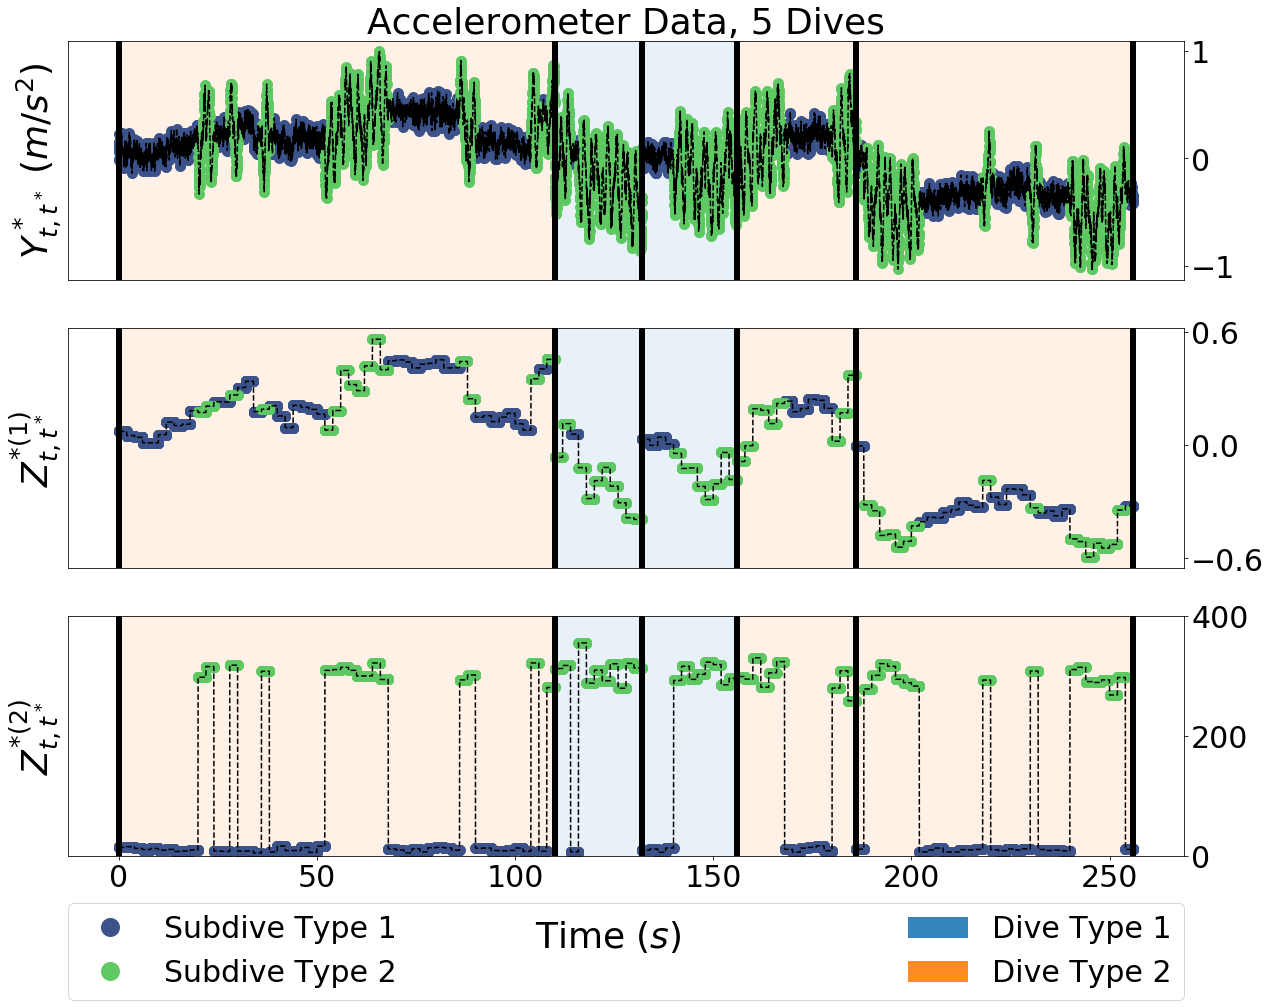

In [11]:
data = datasets[0]

fig,ax = plt.subplots(3,1,figsize=(20,15))
ax[0].yaxis.tick_right()
ax[1].yaxis.tick_right()
ax[2].yaxis.tick_right()

plot_col('A',data,'subdive',1,ax[0])
ax[0].set_title('Accelerometer Data, 5 Dives', fontsize = 36)
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize = 36)
ax[0].set_yticks([-1.0,0,1.0])
ax[0].set_xticks([])
for item in ax[0].get_yticklabels():
    item.set_fontsize(30)

plot_col('avg_A',data,'subdive',0,ax[1])
ax[1].set_ylabel('$Z^{*(1)}_{t,t^*}$', fontsize = 36)
ax[1].set_xticks([])
ax[1].set_yticks([-0.6,0,0.6])
for item in ax[1].get_yticklabels():
    item.set_fontsize(30)

plot_col('FoVeDBA',data,'subdive',0,ax[2],legend=True,size=30)
ax[2].set_ylabel('$Z^{*(2)}_{t,t^*}$',fontsize = 36)
ax[2].set_ylim([0,400])
ax[2].set_yticks([0,200,400])
for item in ax[2].get_xticklabels():
    item.set_fontsize(30)
for item in ax[2].get_yticklabels():
    item.set_fontsize(30)
    
fig.text(0.5, 0.04, 'Time ($s$)', ha='center',fontsize=36)

plt.savefig("../Plots/sim_data.png")

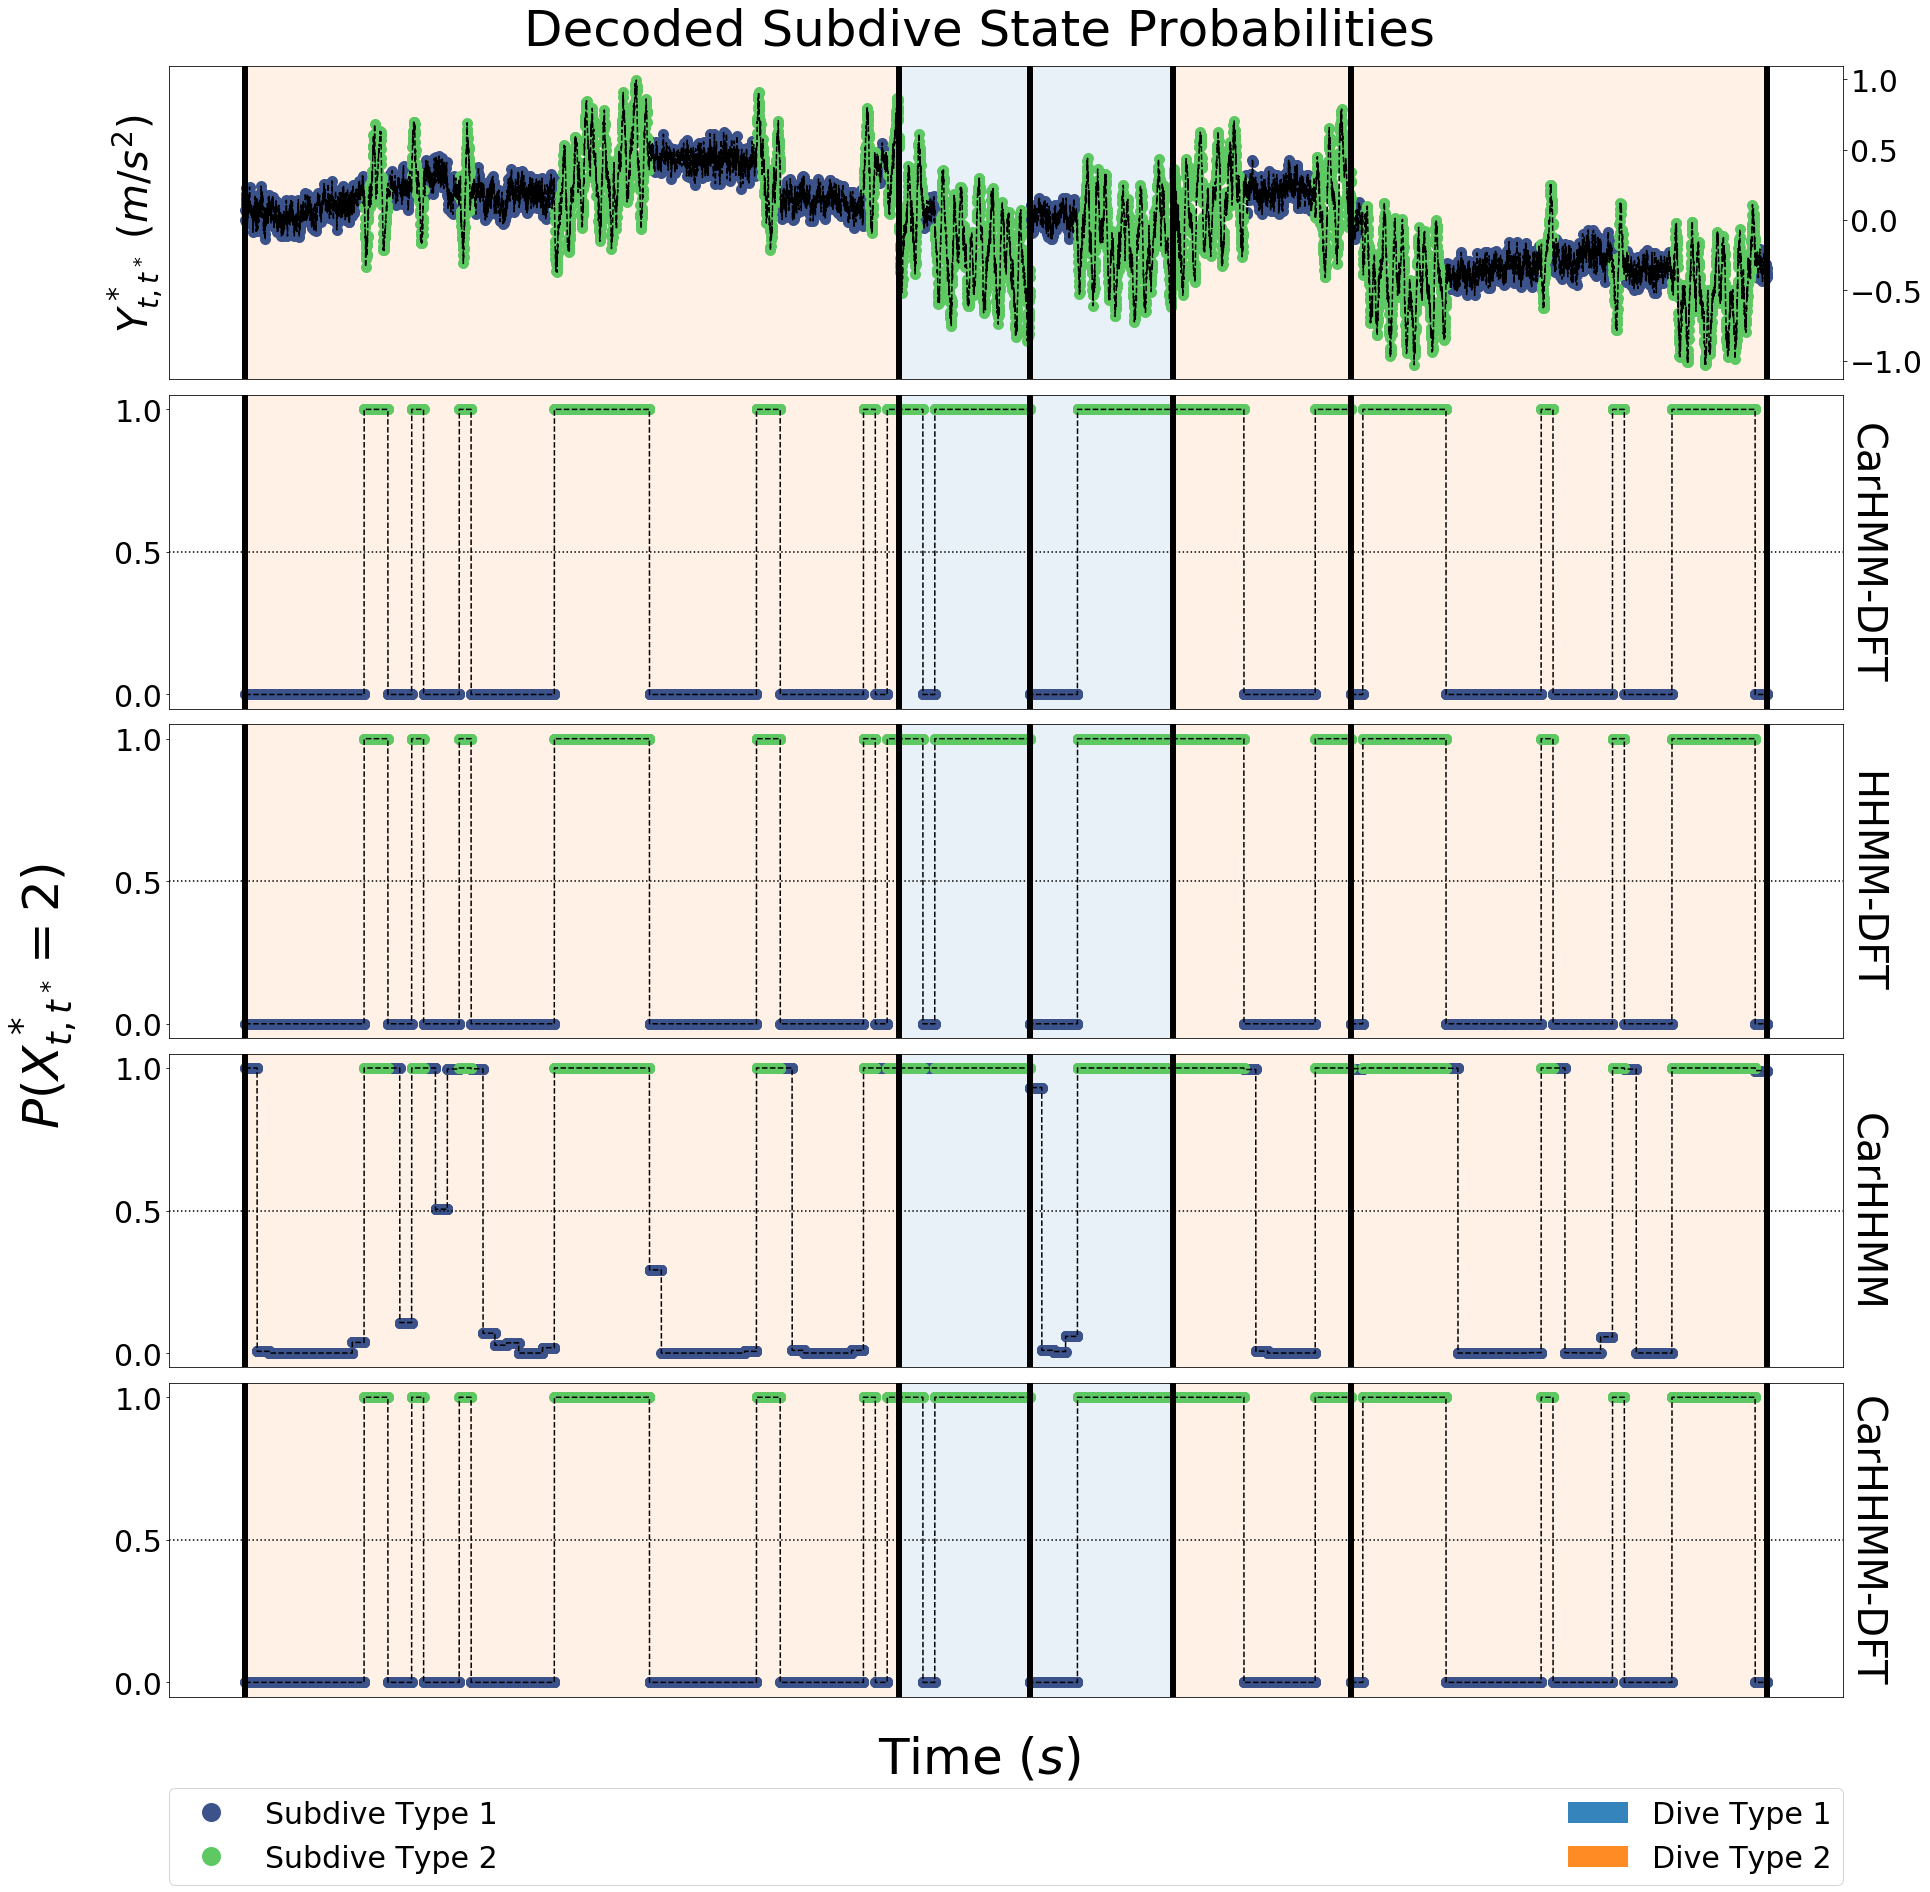

In [12]:
fig,ax = plt.subplots(5,1,figsize=(30,30),sharex=True)
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")
ax[4].yaxis.set_label_position("right")

plot_col('A',data,'subdive',1,ax[0])
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=40)
ax[0].set_xticks([])
ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(30)

plot_col('hmm_FV_subdive',data,'subdive',0,ax[1])
ax[1].set_ylabel("CarHMM-DFT",fontsize=40,rotation=270)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':')
ax[1].yaxis.set_label_coords(1.025,0.5)
for item in ax[1].get_yticklabels():
    item.set_fontsize(30)

plot_col('hhmm_FV_uncorr_subdive',data,'subdive',0,ax[2])
ax[2].set_ylabel("HHMM-DFT",fontsize=40,rotation=270)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':')
ax[2].yaxis.set_label_coords(1.025,0.5)
for item in ax[2].get_yticklabels():
    item.set_fontsize(30)


plot_col('hhmm_V_subdive',data,'subdive',0,ax[3])
ax[3].set_ylabel("CarHHMM",fontsize=40,rotation=270)
ax[3].set_xticks([])
ax[3].set_yticks([0,0.5,1.0])
ax[3].yaxis.set_label_coords(1.025,0.5)
ax[3].axhline(0.5,color='k',linestyle=':')
for item in ax[3].get_yticklabels():
    item.set_fontsize(30)

plot_col('hhmm_FV_subdive',data,'subdive',0,ax[4],legend=True,size=30)
ax[4].set_ylabel("CarHHMM-DFT",fontsize=40,rotation=270)
ax[4].set_yticks([0,0.5,1.0])
ax[4].yaxis.set_label_coords(1.025,0.5)
ax[4].axhline(0.5,color='k',linestyle=':')
for item in ax[4].get_yticklabels():
    item.set_fontsize(30)
for item in ax[4].get_xticklabels():
    item.set_fontsize(30)

fig.text(0.5, 0.89, 'Decoded Subdive State Probabilities', ha = 'center', fontsize=50)
fig.text(0.5, 0.09, 'Time ($s$)', ha='center',fontsize=50)
fig.text(0.05, 0.45, '$P(X^*_{t,t^*} = 2)$', va='center', rotation='vertical',fontsize=50)
plt.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig('../Plots/Posterior_Fine_States.png')

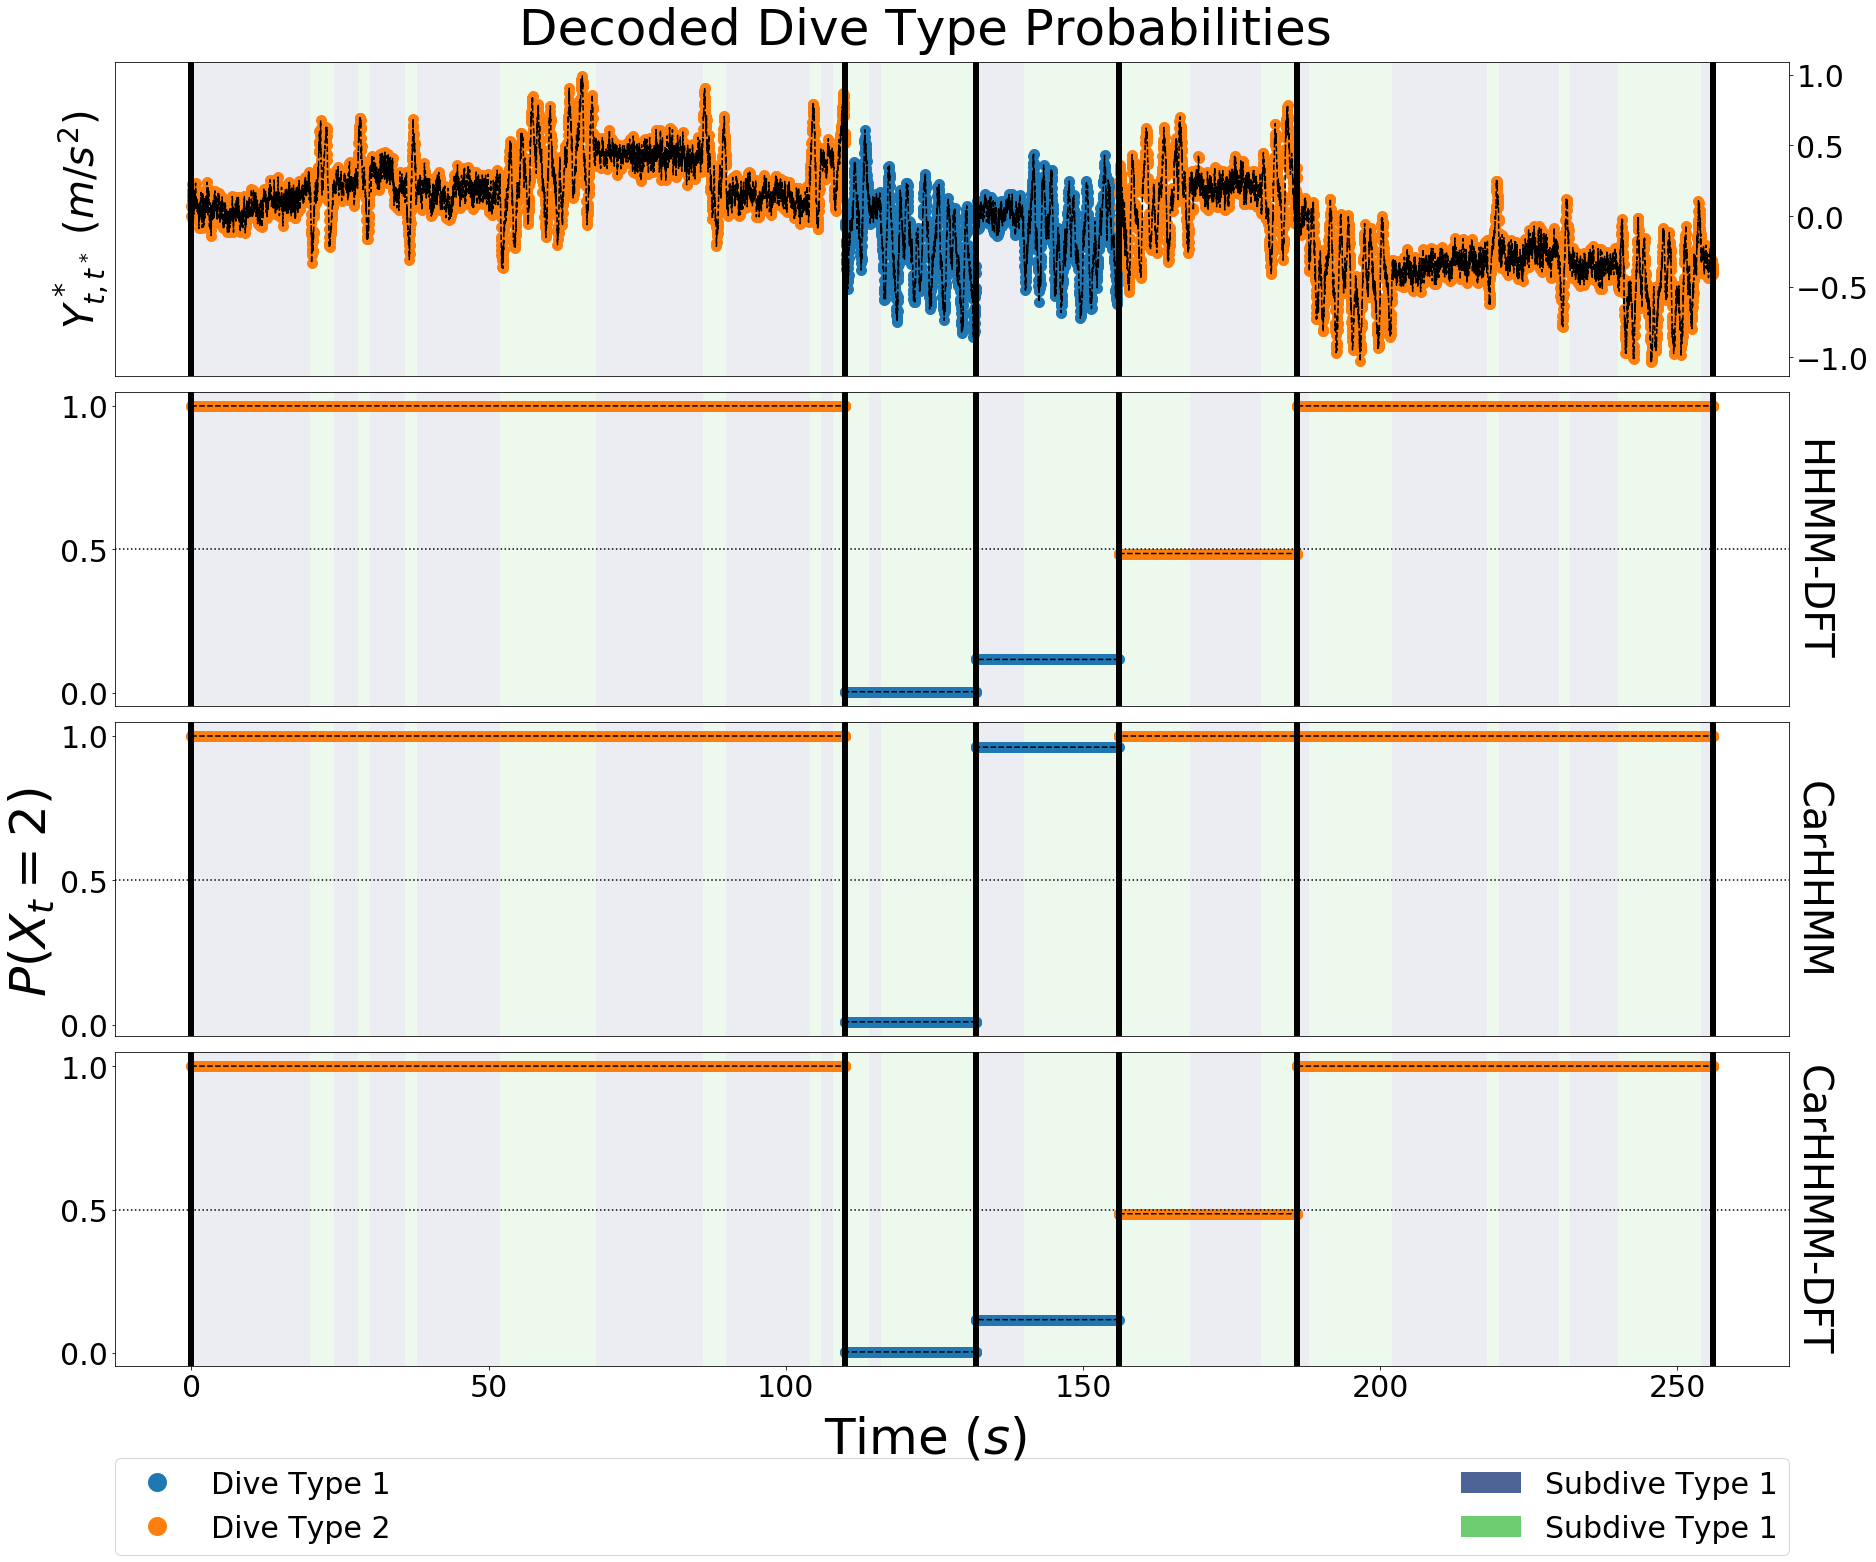

In [13]:
fig,ax = plt.subplots(4,1,figsize=(30,24))
ax[0].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[3].yaxis.set_label_position("right")

plot_col('A',data,'dive',1,ax[0])
ax[0].set_ylabel('$Y^*_{t,t^*}$ $(m/s^2)$', fontsize=40)
ax[0].set_xticks([])
ax[0].set_yticks([-1.0,-0.5,0,0.5,1.0])
for item in ax[0].get_yticklabels():
    item.set_fontsize(30)

plot_col('hhmm_FV_uncorr_dive',data,'dive',0,ax[1])
ax[1].set_ylabel("HHMM-DFT",fontsize=40,rotation=270)
ax[1].yaxis.set_label_coords(1.025,0.5)
ax[1].set_xticks([])
ax[1].set_yticks([0,0.5,1.0])
ax[1].axhline(0.5,color='k',linestyle=':')
for item in ax[1].get_yticklabels():
    item.set_fontsize(30)


plot_col('hhmm_V_dive',data,'dive',0,ax[2])
ax[2].set_ylabel("CarHHMM",fontsize=40,rotation=270)
ax[2].yaxis.set_label_coords(1.025,0.5)
ax[2].set_xticks([])
ax[2].set_yticks([0,0.5,1.0])
ax[2].axhline(0.5,color='k',linestyle=':')
for item in ax[2].get_yticklabels():
    item.set_fontsize(30)

plot_col('hhmm_FV_dive',data,'dive',0,ax[3],legend=True,size=30)
ax[3].set_ylabel("CarHHMM-DFT",fontsize=40,rotation=270)
ax[3].yaxis.set_label_coords(1.025,0.5)
ax[3].set_yticks([0,0.5,1.0])
ax[3].axhline(0.5,color='k',linestyle=':')
for item in ax[3].get_yticklabels():
    item.set_fontsize(30)
for item in ax[3].get_xticklabels():
    item.set_fontsize(30)

fig.text(0.5, 0.89, 'Decoded Dive Type Probabilities', ha = 'center', fontsize=50)
fig.text(0.5, 0.075, 'Time ($s$)', ha='center',fontsize=50)
fig.text(0.075, 0.4, '$P(X_t = 2)$', va='center', rotation='vertical',fontsize=50)
plt.subplots_adjust(wspace=0, hspace=0.05)

plt.savefig('../Plots/Posterior_Coarse_States.png')

# Record Standard Errors

In [14]:
h = 0.001
hmm_FV.get_SEs(data_FV,h)
hhmm_FV_uncorr.get_SEs(data_FV,h)
hhmm_V.get_SEs(data_V,h)
hhmm_FV.get_SEs(data_FV,h)

/Users/evsi8432/Documents/Research/Whale_Research/Repository/Code/HHMM.py:794: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/evsi8432/Documents/Research/Whale_Research/Repository/Code/HHMM.py:851: RuntimeWarning:

divide by zero encountered in double_scalars



0 1
0.00024325606356556865
-935.5447884756431
-935.5509096096725
-935.5387268609646

1 0
0.00024181489493969649
-935.5447884756431
-935.539509918537
-935.5501175729387

0 1
0.0004702534660806223
-1575.1303032130936
-1575.132070180272

1 0
0.0004012230706290093
-1575.131049228581
-1575.1313218445118

0 1
0.0004644890557699481
-1575.1311843765357
-1575.1326552917699
-1575.1297198838636

1 0
0.00012031567492082564
-1575.1311843765357
-1575.1316801460111
-1575.1306944450528

0 1
0.00021544759939781682
-1575.1311843765357
-1575.1353143628419
-1575.1271011775923

1 0
0.00030867656363604633
-1575.1311843765357
-1575.126070341579
-1575.136344601759

0 1
0.00030315373682680103
221.61883950730174
221.61777273157747

1 0
0.0004091652447427688
221.6169252309452
221.61968447326467

0 1
1.7333056490098647e-10
221.61830688649167
221.61830688654317
221.61830688644008

1 0
6.758693606111866e-05
221.61830688649167
221.61671104414503
221.6199019557803

0 1
0.00011021168204158351
221.61830688649167
221.61

{'dive_duration': {'mu': [2.5229691553945806, 20.21169431171043],
  'sig': [1.5748126089944139, 13.780064667863765],
  'corr': [inf, inf]},
 'FoVeDBA': {'mu': [0.21691599606541584, 1.4545885489393942],
  'sig': [0.1785660088506366, 1.0731185152653877],
  'corr': [inf, inf]},
 'A': {'mu': [0.6491858005065623, 0.12012058597421592],
  'sig': [0.002733748711678376, 0.004312515285394212],
  'corr': [0.005631745238673138, 0.023647427704342184]},
 'Gamma_coarse': array([[0.        , 0.21828913],
        [0.26341725, 0.        ]]),
 'Gamma_fine': [array([[0.        , 0.18324424],
         [0.04979659, 0.        ]]),
  array([[0.        , 0.03149759],
         [0.04541815, 0.        ]])]}

# Make Confusion Matrix on Test data

In [15]:
data,data_V,data_FV = create_data()

### HMM ###

for dive_num,datum in enumerate(data_FV):
    _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    for i,post in enumerate(posts.T):
        data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
        data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hmm_FV_subdive'])
        
hmm_FV.CM = [CM_coarse,CM_fine]
        
### HHMM ###

# crude posterior
_,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_uncorr_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_uncorr_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_uncorr_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_uncorr_subdive'])
        
hhmm_FV_uncorr.CM = [CM_coarse,CM_fine]
        
        
### CarHHMM, no Z2 ###

# crude posterior
_,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

# fine posterior
for dive_num,datum in enumerate(data_V):
    data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        if i%2 == 0:
            p0 = p
        else:
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_subdive'] = (p*p0)/(p*p0+(1.-p)*(1.-p0))
            data[dive_num]['subdive_features'][int((i-1)/2)]['hhmm_V_dive'] = posts_crude.T[dive_num,1]


# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_V_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_V_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_V_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_V_subdive'])
        
hhmm_V.CM = [CM_coarse,CM_fine]           


    
### CarHHMM ###
            
# crude posterior
_,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]   
        
# get confusion matrix
CM_coarse = np.zeros((2,2))
CM_fine = [np.zeros((2,2)),np.zeros((2,2))]
for dive in data:
    dive_type = dive['dive_type']
    CM_coarse[dive_type,1] += dive['subdive_features'][0]['hhmm_FV_dive']
    CM_coarse[dive_type,0] += max(0,1.0-dive['subdive_features'][0]['hhmm_FV_dive'])
    for seg in dive['subdive_features']:
        subdive_type = seg['subdive_type']
        CM_fine[dive_type][subdive_type,1] += seg['hhmm_FV_subdive']
        CM_fine[dive_type][subdive_type,0] += max(0,1.0-seg['hhmm_FV_subdive'])
        
hhmm_FV.CM = [CM_coarse,CM_fine]

In [16]:
### CarHMM ###
print(hmm_FV.theta)
print(hmm_FV.SEs)
print('')
print(hmm_FV.train_time)
print('')
print(hmm_FV.CM[0])
print('')
print(hmm_FV.CM[1])

[{'dive_duration': {'mu': array([51.12717932]), 'sig': array([40.63665631]), 'corr': array([-10.])}}, [{'FoVeDBA': {'mu': array([ 10.19266639, 306.49920256]), 'sig': array([ 3.26802376, 17.90788031]), 'corr': array([-10., -10.])}, 'A': {'mu': array([-0.36184224, -0.00170784]), 'sig': array([0.04899739, 0.0941656 ]), 'corr': array([5.21856718, 2.675439  ])}}]]
{'dive_duration': {'mu': [8.414937455662471], 'sig': [7.5912051471254705], 'corr': [inf]}, 'FoVeDBA': {'mu': [0.21691161939881684, 1.4544874414703641], 'sig': [0.17854065168854727, 1.0731499167253475], 'corr': [inf, inf]}, 'A': {'mu': [0.6582586218874927, 0.12012056469350399], 'sig': [0.0027337676163700178, 0.004312515235513901], 'corr': [0.005576232684626802, 0.02364742726543318]}, 'Gamma_coarse': array([[0.]]), 'Gamma_fine': [array([[0.        , 0.03153077],
       [0.03401454, 0.        ]])]}

23330.448179244995

[[5. 0.]
 [6. 0.]]

[array([[6.00000000e+000, 1.90106743e-245],
       [0.00000000e+000, 3.70000000e+001]]), array([